In [27]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib inline

import simcado as sim
from photutils import centroid_2dg

# SimCADO on the sub-pixel scale

In the normal imaging modes (4mas, 1.5mas) sub-pixel scale effects aren't taken into account. This is because for science cases which are more interested in large-scale structure, or are happy with simple photometric measurements, the effects on sub-pixel scales don't make a huge difference to the outcome. Plus simulating large images with sub-pixel accuracy takes a lot of computing power. Hence why the default is to not worry about these scales. 

There are however numerous cases which require SimCADO to look at the sub-pixel level. In this notebook we show the basics of how to get SimCADO to take notice of the finer aspects of observing.

.. note:: 
    The astropy affiliated package ``photutils`` is needed to run this notebook. It is **not** needed to run SimCADO.  
    https://photutils.readthedocs.io/en/stable/

### SimCADO functionality used here

## Set up an appropriate optical train

Before we jump in to simulating, lets have a look at what we're working with. We haven't yet put access to the sub-pixel functionality into the one-call-to-rule-them-all function (i.e. ``simcado.run()`` ), so we need to build up our own simulation from SimCADO's lego bricks. The main steps are:

1. Create a commands object with ``simcado.UserCommands()``
    * Use ``SIM_DETECTOR_PIX_SCALE`` to set the plate scale we want, i.e. 1.5mas for zoom mode, or 4mas for wide-field mode  
      **Note** that ``SIM_DETECTOR_PIX_SCALE`` is in [arcsec]
    * Set up the detector window that we would like to read out with ``FPA_CHIP_LAYOUT``  
      Here we chose a 16x16 pixel window around our star, just to see what's happening
    
2. Create the optical train by passing the commands to ``simcado.OpticalTrain(cmds=...)``
3. Create the detector by passing the commands to ``simcado.OpticalTrain(cmds=...)``

.. note:: 
    We can turn off the PSF by setting ``SCOPE_PSF_FILE`` to ``None``. This gives us a delta function instead.
    
        >>> cmd["SCOPE_PSF_FILE"] = None
        

In [28]:
cmd = sim.UserCommands()
cmd["SIM_DETECTOR_PIX_SCALE"] = 0.0015
# our read out window
cmd["FPA_CHIP_LAYOUT"] = """
#  id    x_cen    y_cen   x_len   y_len     gain
   0     0        0       32     32       1
"""
#cmd["SCOPE_PSF_FILE"] = None
opt = sim.OpticalTrain(cmd)
fpa = sim.Detector(cmd, small_fov=False)

### Check the PSF

Just to be sure we know what we're dealing with, lets look at the PSF. The array of wavelength-dependent PSFs are found in ``<OpticalTrain>.psf``. It will be helpful later to know where the centroid of the PSF is, so lets get that too

Centroid of PSF 1.65910793787 1.65940081576


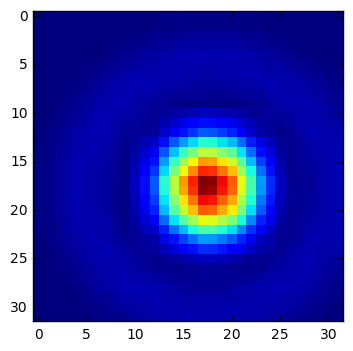

In [29]:
s = opt.psf[0].size // 2
q = 16
im = opt.psf[0].array[s-q:s+q,s-q:s+q]
plt.imshow(im, interpolation="none")

from photutils import centroid_2dg
dx_psf, dy_psf = np.array(centroid_2dg(im)) - np.array((q,q))
print("Centroid of PSF", dx_psf, dy_psf)

## Create a star
Now lets create a star to play with using ``simcado.source.star()``. To begin with, it will sit at the origin (0,0)

In [30]:
star = sim.source.star(mag=20, x=0., y=0.)

Now let's make sure it is where we want it to be after SimCADO has had its way with the source object. When we apply the optical train to the source, we need to use the keyword sub_pixel=True

    >>> star.apply_optical_train(..., sub_pixel=True)
    
When we call ``apply_optical_train()`` we need to specify both an ``OpticalTrain`` object and a ``Detector`` object, otherwise SimCADO won't know what to do with the photons, or where to put them. And don't forget ``sub_pixel=True``

In [31]:
star.apply_optical_train(opt, fpa, sub_pixel=True)

Generating image for chip 0


.. note::
    The Detector object holds the expected photon flux (ph/s/pixel) for the detectors. Thus an easy way to see what is going 
    on with out "real life" getting in the way (i.e. before noise is applied), is to look inside the detector, rather than at
    the read-out FITS file.
    
Here we can use the 2D gaussian centroiding function from the package ``phot_utils`` to find where the centre of the star is. Because of the way the PSF file is constructed, it is not centred on pixle (16,16), **but rather is off-centre by 1.67 pixels in both directions**.

(17.659443672323182, 17.659149005987782)

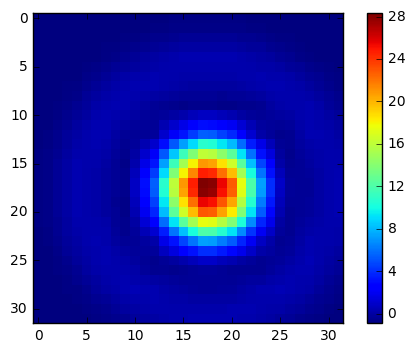

In [32]:
plt.imshow(fpa.chips[0] - np.median(fpa.chips[0]),  interpolation="none")
plt.colorbar()

from photutils import centroid_2dg
y,x = centroid_2dg(fpa.chips[0])
x,y

### Move the star around

Given that the plate scale is 4mas, lets shift the star by ``(dx,dy) = (-5mas, -0.3mas)``

Generating image for chip 0
Induced shift [mas]: -5.0 -0.3
Detected shift [mas]:  -4.99724967799 -0.296555393801


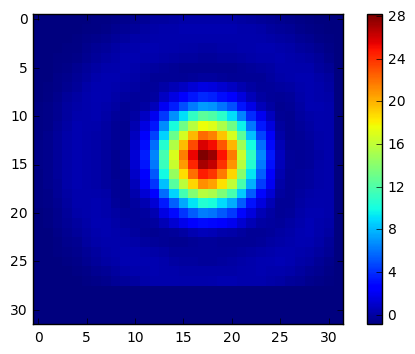

In [33]:
dx1, dy1 = -5E-3, -0.3E-3
star.shift(dx1, dy1, use_orig_xy=True)
star.apply_optical_train(opt, fpa, sub_pixel=True)

plt.imshow(fpa.chips[0] - np.median(fpa.chips[0]), interpolation="none")
plt.colorbar()

y2, x2 = centroid_2dg(fpa.chips[0])
print("Induced shift [mas]:", dx1*1E3, dy1*1E3)
print("Detected shift [mas]: ", 1.5*(x2-x), 1.5*(y2-y))

## Add (pseudo) reality to the image

Until now we've only been working with the expected flux values in the ``Detector`` object. To "observe" the object we need to read the ``Detector`` out into a FITS file. This takes into account the exposure time and adds in the read out electronic noise. It also applies random poisson noise to the image to simulate photon shot noise.

Using the defaults: an exposure time of 60 seconds in Ks-band.

Reading out chip 0
Induced shift [mas]: -5.0 -0.3
Detected shift [mas]:  -5.01623933281 -0.33620023214


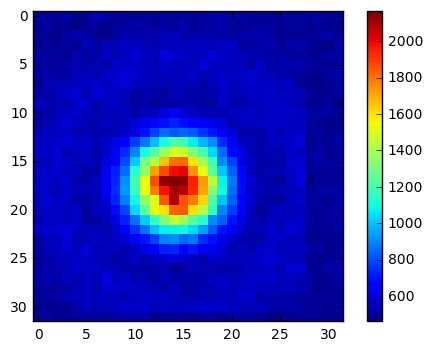

In [34]:
hdu = fpa.read_out()

plt.imshow(hdu[0].data, interpolation="none")
plt.colorbar()

x3, y3 = centroid_2dg(hdu[0].data)#
print("Induced shift [mas]:", dx1*1E3, dy1*1E3)
print("Detected shift [mas]: ", 1.5*(x3-x), 1.5*(y3-y))

### Code Summary

In [35]:
# Load a command object
cmd = sim.UserCommands()
cmd["SIM_DETECTOR_PIX_SCALE"] = 0.0015
# our read out window
cmd["FPA_CHIP_LAYOUT"] = """
#  id    x_cen    y_cen   x_len   y_len     gain
   0     0        0       32     32       1
"""

# make the optical system
opt = sim.OpticalTrain(cmd)
fpa = sim.Detector(cmd, small_fov=False)

# make a star and "observe"
star = sim.source.star(mag=20, x=0., y=0.)
star.shift(-5E-3, -0.3E-3, use_orig_xy=True)
star.apply_optical_train(opt, fpa, sub_pixel=True)

# read out the detector
hdu = fpa.read_out()

Generating image for chip 0
Reading out chip 0


## Lets go big - a 100 Msun cluster

If we assume our cluster is concentrated with a half-light-radius of 0.1pc, and it has an on-sky size of 0.4", that will mean it lies at a distance of ~50kpc (LMC)

In [36]:
clust = sim.source.cluster(mass=100, distance=50E3, half_light_radius=0.1)

If we're going to look at a cluster, we're need a larger detector window, say the inner 1024 pixels of the detector. There just so happens to be a preset for this built into the ``Detector`` (more as a safety mechanism than anything else) - ``small_fov=True``

In [37]:
cmd = sim.UserCommands()
cmd["SIM_DETECTOR_PIX_SCALE"] = 0.0015

opt = sim.OpticalTrain(cmd)
fpa = sim.Detector(cmd, small_fov=True)

clust.apply_optical_train(opt, fpa, sub_pixel=True)

Safety switch is on - Detector(..., small_fov='True')
Generating image for chip 0


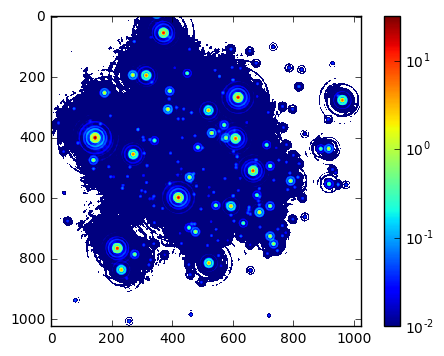

In [38]:
im = fpa.chips[0] - np.median(fpa.chips[0]) * (1-5E-6)
plt.imshow(im, interpolation="none", norm=LogNorm(), vmin=1E-2)
plt.colorbar()

### The reality check

Looks like we'll need to observe for quite a while to see these stars, so lets see what would be observable in 60 minutes:

Reading out chip 0


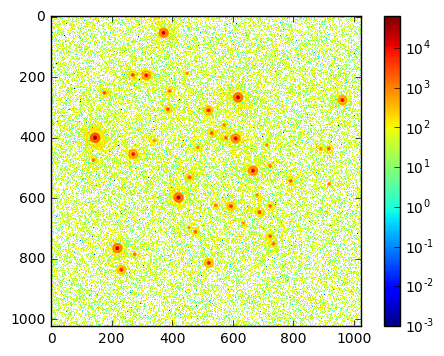

In [39]:
hdu = fpa.read_out(OBS_EXPTIME=3600)

im = (hdu[0].data - np.median(hdu[0].data)).T
plt.imshow(im, interpolation="none", norm=LogNorm())
plt.colorbar()

### Check the positions of the stars
Because we have the (dRA, dDec) coordinates of the stars in our ``Source`` object, we can pull out a 16x16 pixel square from the image and run the centroiding function to see how close the stars are to where they should be.

The cluster ``Source`` object contains the data of the stars inside it, in a dictionary called ``.info``. Therefore to make sure we only extract stars that are "visible", we can set a mass limit. In this case, we'll set the mass limit 0.3 solar masses.

.. hint:: 
    To find what keywords is available in the ``<Source>.info`` dictionary, use the property ``<Source>.info_keys``. 
    Then call the dictionary entry that you need:
    
        >>> clust.info_keys
        dict_keys(['stel_type', 'distance', 'hwhm', 'total_mass', 'created', 
                   'masses', 'object', 'description', 'half_light_radius'])
        >>> clust.info["distance"]
        50000.0 pc

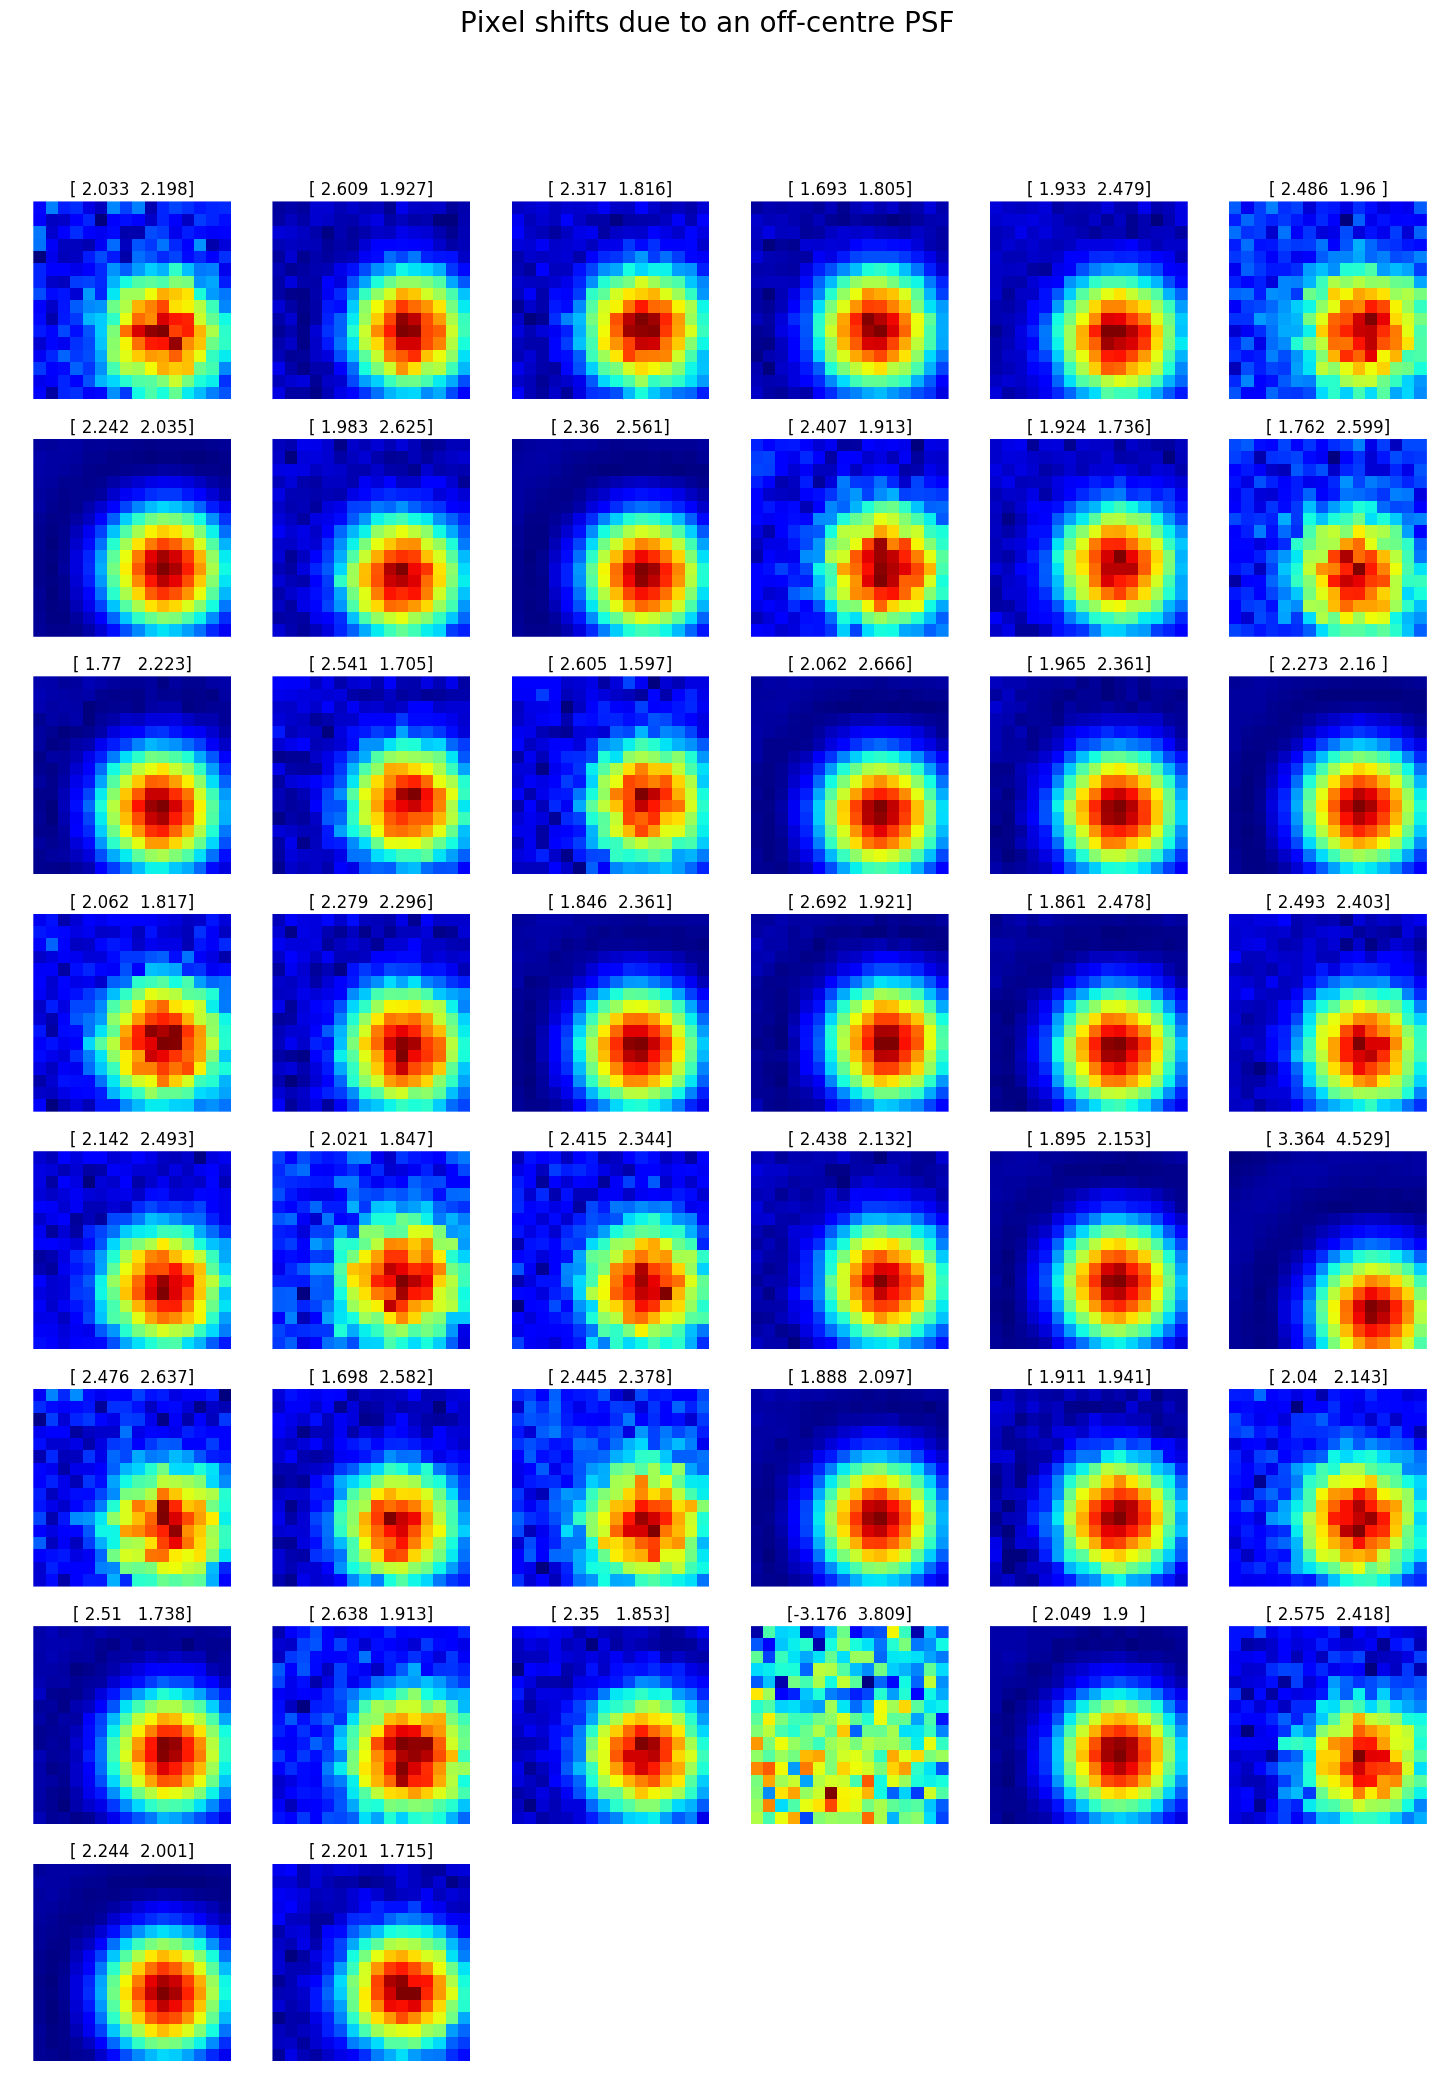

In [40]:
# convert real coords to image coords
# (x,y) are between [0,2] arcsec. Centre of image is (512,512) pixels
x = clust.x_orig / 0.0015 + 512
y = clust.y_orig / 0.0015 + 512

# get a control field for the BG noise and the extraction threshold
bg_sig = np.std(im[:50,:50])
threshold = 5 * bg_sig
mass_limit = 0.3     # solar masses

# set the extraction box radius
q = 8

# extract the stars
ims, iis = [], []
shift = []
for xx, yy, ii in zip(x, y, range(len(x))):
    cutout = im[xx-q:xx+q,yy-q:yy+q]
    try: 
        if clust.info["masses"][ii] > mass_limit and np.max(cutout) > threshold:
            ims += [cutout]
            iis += [ii]
            ################################################################
            # NOTE - centroid returns (dy, dx), not (dx, dy) as advertised #
            ################################################################
            shift += [np.array(centroid_2dg(cutout) - np.array((q,q)))]
            
    except:
        pass
    
# plot the stars that made it out alive
n = 6
m = len(ims) // n + 1
plt.figure(figsize=(n*3,m*3))

for i in range(len(ims)):   
    plt.subplot(m,n,i+1)
    plt.imshow(ims[i], interpolation="none")
    plt.axis("off")
    plt.title(np.round(shift[i], 3))

plt.suptitle("Pixel shifts due to an off-centre PSF", fontsize=20)
#plt.tight_layout()

### Remember the PSF offset

As we saw earlier, the PSF itself was offset from the centre of the image by ~1.7 pixels. When we take that into account, we see that the average shift in the position of the stars is ~0.5 pixels. This can be attributed to the integer nature of the images operations. It appears that SimCADO loses half a pixel somewhere. Fear not though, we will look into this shift and update future versions of SimCADO to correct for this. In the meantime though, please don't forget to take this 0.5 pixel shift into account.

Meidan shift in x,y:  0.562233733575 0.488543462008


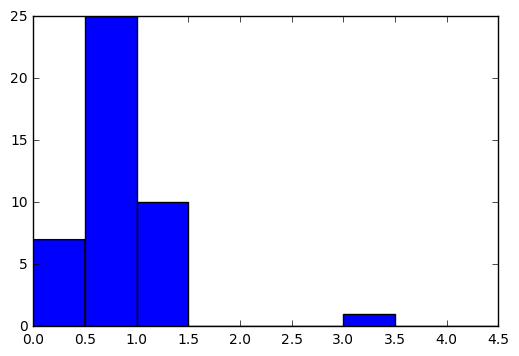

In [41]:
shift = np.array(shift) - np.array((dx_psf, dy_psf))
plt.hist(np.sqrt(shift[:, 0]**2 + shift[:, 1]**2), bins=np.arange(0,5,0.5))
print("Meidan shift in x,y: ", np.median(shift[:,0]), np.median(shift[:,1]))

## Adding random shifts to the cluster stars

Lets add some random variation to the positions of the cluster stars - up to 5mas in x and y - and see whether we can recover this variation. To do this we:
1. take the cluster from before (don't generate a new one, otherwise we lose the positions) and shift the positions slightly
2. extract the same 16x16 pixel boxes from the new image
3. measure the centroids of the new stars
4. calculate the difference between the centroids of the old and the new star [in pixels]
4. correct for the offset of the PSF centroid and the 0.5 pixel that SimCADO sneaks in
5. convert this offset back from pixels to arcseconds
6. plot the measured offset (``shift_mean``) vs the "true offset" that we generated at the beginning (``dx``)
7. Find the median and stdev for the difference between true and measured offsets

In [42]:
dx, dy = np.random.random(size=(2, len(clust.x))) * 0.005

clust.shift(dx=dx, dy=dy, use_orig_xy=True)
clust.apply_optical_train(opt, fpa, sub_pixel=True)
hdu = fpa.read_out(OBS_EXPTIME=3600)

#im2 = fpa.chips[0].array
im2 = (hdu[0].data - np.median(hdu[0].data)).T

Generating image for chip 0
Reading out chip 0


In [43]:
# extract the stars
ims2, shift2 = [], []
for ii in iis:
    cutout = im2[x[ii]-q:x[ii]+q, y[ii]-q:y[ii]+q]
    try: 
        ims2 += [cutout]
        ##################################################
        # NOTE - centroid returns (dy, dx), not (dx, dy) #
        ##################################################
        shift2 += [np.array(centroid_2dg(cutout) - np.array((q,q)))]
    except:
        pass

# take into account the PSF offset and the 0.5 pixel that SimCADO adds in
shift_meas = np.array(shift2) - np.array((dx_psf, dy_psf)) - np.array((0.5, 0.5))

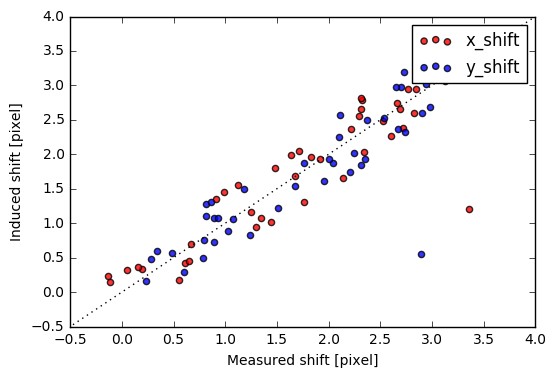

In [44]:
plt.scatter(shift_meas[:,1], dx[iis] / 0.0015, c="r", alpha=0.8, label="x_shift")
plt.scatter(shift_meas[:,0], dy[iis] / 0.0015, c="b", alpha=0.8, label="y_shift")

plt.legend(); plt.plot([-2,5], [-2,5], "k:")
plt.xlim(-0.5,4); plt.ylim(-0.5,4)
plt.xlabel("Measured shift [pixel]"); plt.ylabel("Induced shift [pixel]")

Median and St. Dev. of the residual offset [pix]: 0.378732037804 0.418189294562


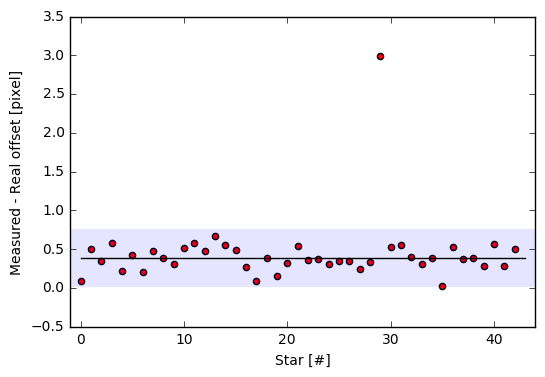

In [45]:
dpix = np.array((dy[iis], dx[iis])).T / 0.0015
diff = np.sqrt(np.sum((shift_meas - dpix)**2, axis=1))

m = diff < 6         # Remove the shifts for the stars which weren't real stars (i.e. Airy disks)
diff = diff[m]

plt.plot([0, len(diff)], (np.median(diff), np.median(diff)), linewidth=np.std(diff)*100, alpha=0.1)
plt.plot([0, len(diff)], (np.median(diff), np.median(diff)), c="k")

plt.scatter(np.arange(len(diff)),diff, c="r")
#plt.scatter(np.arange(len(r_real)), r_meas - r_real, c="r")
plt.xlim(-1, len(diff)+1) #; plt.ylim(-2, 2)
plt.xlabel("Star [#]"); plt.ylabel("Measured - Real offset [pixel]")

print("Median and St. Dev. of the residual offset [pix]:", np.median(diff), np.std(diff))

### Conclusion: we need a better method to extract the shift of the stars

Although the shift in a stand-alone star is measurable down to a fraction of a pixel, when applying a simple centroiding algorithm to the stars in a cluster, we lose the ability to determine the centre of the star to less than 0.5 pixels properly. To improve on this, we will either need more data points so that we can reduce the poisson noise in the "observed" images and therefore find better find the star centres.